In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from NerualOperatorClass import FNO1d
import matplotlib.pyplot as plt
from torch.optim import Adam

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

n_train =100

x_data = torch.from_numpy(np.load("data/AC_data_input.npy")).type(torch.float32)
y_data = torch.from_numpy(np.load("data/AC_data_output.npy")).type(torch.float32)

temporary_tensor = torch.clone(x_data[:, :, 0])
x_data[:, :, 0] = x_data[:, :, 1]
x_data[:, :, 1] = temporary_tensor


input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]



In [3]:
batch_size = 10
learning_rate = 0.001

epochs = 250
step_size = 50
gamma = 0.5

modes = 16
width = 64

# model

fno = FNO1d(modes, width)

In [4]:
training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)


In [5]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.3099167712032795  ######### Relative L2 Test Norm: 37.38681439293755
######### Epoch: 1  ######### Train Loss: 0.06940705142915249  ######### Relative L2 Test Norm: 25.331362766689725
######### Epoch: 2  ######### Train Loss: 0.03973820209503174  ######### Relative L2 Test Norm: 18.34182447857327
######### Epoch: 3  ######### Train Loss: 0.022988540306687354  ######### Relative L2 Test Norm: 15.814628675248887
######### Epoch: 4  ######### Train Loss: 0.01695291046053171  ######### Relative L2 Test Norm: 13.422665617201064
######### Epoch: 5  ######### Train Loss: 0.012112271972000599  ######### Relative L2 Test Norm: 12.643834659788343
######### Epoch: 6  ######### Train Loss: 0.010922795906662942  ######### Relative L2 Test Norm: 11.415818452835083
######### Epoch: 7  ######### Train Loss: 0.00946198431774974  ######### Relative L2 Test Norm: 10.625294754240247
######### Epoch: 8  ######### Train Loss: 0.007223067106679082  ######### Relati

tensor([[[ 0.0000, -1.0000],
         [ 0.0182, -0.9980],
         [ 0.0365, -0.9960],
         ...,
         [-0.0365,  0.9960],
         [-0.0182,  0.9980],
         [ 0.0000,  1.0000]],

        [[ 0.0000, -1.0000],
         [ 0.0615, -0.9980],
         [ 0.1229, -0.9960],
         ...,
         [-0.1229,  0.9960],
         [-0.0615,  0.9980],
         [ 0.0000,  1.0000]],

        [[ 0.0000, -1.0000],
         [ 0.0913, -0.9980],
         [ 0.1826, -0.9960],
         ...,
         [-0.1826,  0.9960],
         [-0.0913,  0.9980],
         [ 0.0000,  1.0000]],

        ...,

        [[ 0.0000, -1.0000],
         [-0.0366, -0.9980],
         [-0.0733, -0.9960],
         ...,
         [ 0.0733,  0.9960],
         [ 0.0366,  0.9980],
         [ 0.0000,  1.0000]],

        [[ 0.0000, -1.0000],
         [ 0.0724, -0.9980],
         [ 0.1448, -0.9960],
         ...,
         [-0.1448,  0.9960],
         [-0.0724,  0.9980],
         [ 0.0000,  1.0000]],

        [[ 0.0000, -1.0000],
       

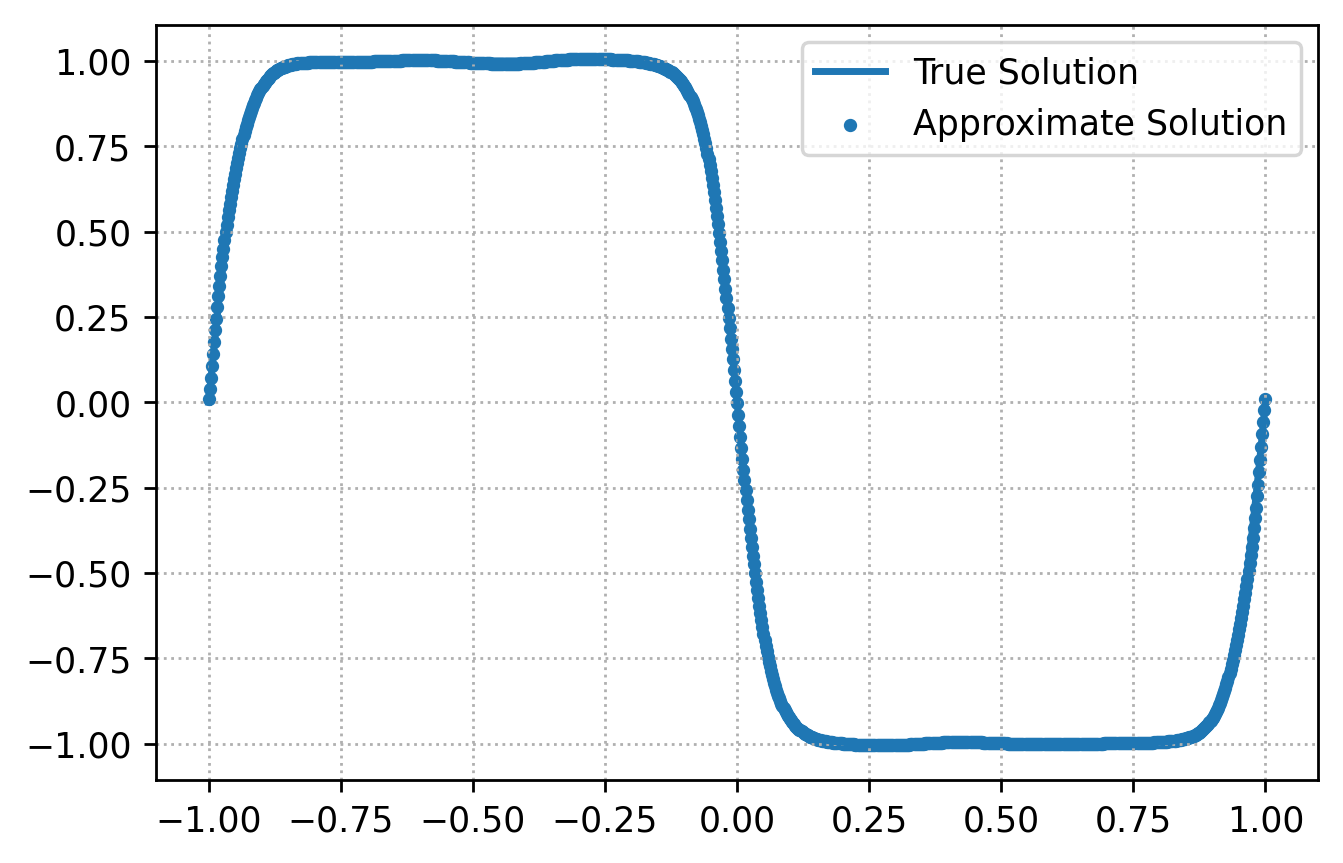

In [6]:
print(input_function_train)
idx_data = 134
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
print(input_function_test_n.shape)
print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n)
print(output_function_test_pred_n.shape)
print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C0")
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()